# Figure 9: Colour plot for probability of Wolbachia invading under the 30 mosquito model with no reversion

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

Import required libraries

In [20]:
import numpy as np
import pylab as plt
import matplotlib
from matplotlib.colors import ListedColormap

Import required scripts

In [22]:
import importlib
import Rate_transitions
import Finding_dictionary_keys
import Prob_absorb_to_each
import Hughes_model

get_transition = Rate_transitions.get_transition_Hughes
find_keys = Finding_dictionary_keys.find_keys
prob_reach_absorb = Prob_absorb_to_each.prob_reach_absorb_Hughes
F = Hughes_model.F#_hughes

# scripts autosave, so no need to re-run code chunk after making changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Construct dictionaries for the full state space and the transient state space (mixed states)

In [23]:
max_pop = 30  # maximum household size
state_dict = {index: np.array((i, j)) for index, (i, j) in enumerate([(i, j) for i in range(max_pop + 1) for j in range(max_pop + 1) if i + j <= max_pop])}
trans_dict = {index: np.array((i,j)) for index, (i,j) in enumerate([(i, j) for i in range(1,max_pop + 1) for j in range(1,max_pop + 1) if i + j <= max_pop])}

Finding the invasion probabilities over a range of $\phi$ values and proportion of Wolbachia-infected mosquitoes introduced.

In [24]:
M0 = 10      # total household size, fixed at wild-type SS value
phivec = np.linspace(0.1,1,19) # range of phi values
phirange = len(phivec)         # length of phi range
invasion_prob1 = np.zeros((phirange,M0+1))   # initialise array for invasion probabilities

# parameter values
K = 30           # reproductive carrying capacity
d1 = 12/100      # wild-type death rate
d2 = 12/100      # Wolbachia death rate
v = 10/10        # probability of verical transmission
u = 10/10        # ratio of unviable offspring produced by an infected male and uninfected female

k = 0.3           # Mosquito competition parameter
h = 0.19*100**k   # Mosquito competition parameter

b1 = round(d1/F(10,K),2)  # wild-type per capita birth rate
indx_vec = np.zeros(M0, dtype=int)   # initialise vector to record indexes of required states

for l in range(M0-1):   # looping over required states i.e. those with a total of M0 mosquitoes
    indx_vec[l] = find_keys(trans_dict, np.array([M0-l-1,l+1]))[0]   # finding the key/ index of the current state

for j in range(phirange):      # looping over the phi values
    for i in range(max_pop):   # looping over the Wolbachia-only states
        # create a dictionary to store all parameter values
        params_dict = {'b1': b1,
                  'b2': b1*phivec[j],  # Wolbachia-only death rate
                  'K': K,
                  'd1': d1,
                  'd2': d2,
                  'v': v,
                  'phi': phivec[j],
                  'u': u,
                  'h': h,
                  'k': k
                  }
        absorb_state = np.array([0,i+1])  # current Wolbachia-only state finding probability of reaching
        # calculating the probability of reaching the current Wolbachia-only state
        probs = np.transpose(prob_reach_absorb(state_dict,trans_dict,absorb_state,params_dict)[0])[0]
        # adding the current probaility to the total invasion probability array
        invasion_prob1[j,1:M0+1] += probs[indx_vec] 
invasion_prob1[:,M0] = 1  # if initial state if Wolbachia-only, then probability of invasion is 1

Finding the values for which the invasion probability is atleast 0.9

In [25]:
high_m = np.where(invasion_prob1 >= 0.9)[0]
high_w = np.where(invasion_prob1 >= 0.9)[1]

Plotting the figure

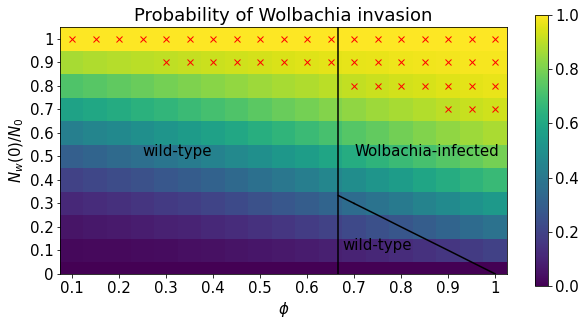

In [41]:
matplotlib.rcParams.update({'font.size': 15})  # font size
plt.figure(figsize=(10, 5))   # figure size

Z = np.transpose(invasion_prob1)  # swap to correct way round
my_cmap = plt.cm.viridis  # colour scheme
num_levels = 100000 # number of levels in colour scheme

my_cmap = ListedColormap(my_cmap(np.linspace(0, 1, num_levels)))  # define how fine a colour scale want
plt.imshow(Z, cmap=my_cmap, interpolation='nearest', origin='lower')  # produces colour plot

plt.ylabel('$N_w(0)/N_0$')   # y label
plt.xlabel('$\phi$')         # x label

# rescaling x and y ticks
plt.yticks([0,1,2,3,4,5,6,7,8,9,10],['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1'])
plt.xticks([0,2,4,6,8,10,12,14,16,18],['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1'])

# loading in invasion threshold results from previous code
inv_thresh = np.load('invasion_thresh.npy')
x_extended = np.linspace(min(phivec[14:]), d1/b1, 100)
y_extended = np.load('invasion_thresh_extended.npy')

phivec = np.arange(0,1.05,0.05) # range of phi values
plt.plot((phivec[14:]-0.1)*20,inv_thresh[14:]*10, 'k') # plot the invasion threshold, have to rescale for the color plot
plt.plot((x_extended-0.1)*20, y_extended*10, 'k')  # plot the extended invasion threshold
plt.axvline(20*(d1/b1-0.1), color='black')  # marks the region in which Wolbachia-only SS exist

plt.ylim(0,10.5)   # y limit
#plt.xlim(8,18)

# labelling the stability and attraction of the steady states
plt.text(3,5,'wild-type')
plt.text(11.5,1,'wild-type')
plt.text(12,5,'Wolbachia-infected')
  
plt.plot(high_m,high_w, 'rx')  # mark the region in which the invasion probability is greater than 0.9

plt.colorbar()    # make colour bar
plt.title('Probability of Wolbachia invasion')   # title

plt.savefig('prob_invade_10_v1_popconserve.pdf', bbox_inches='tight') # save figure